<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/XX_XX_CNN_macaque_pfc.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# CNNs to Decode Intended Saccade Direction from Macaque PFC Microelectrode Recordigns
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --single-branch --branch cboulay/macaque_pfc --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta1
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import enable_plotly_in_cell, reset_keras
%load_ext tensorboard

In [2]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'monkey_pfc'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' )} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Prepare data from one session
TODO: Explain data.

### Load the data
Let's use a helper function from the repo to load the data.
You can see the code for `load_macaque_pfc` [here](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/data/utils/fileio.py)
(TODO: Point to line number).

In [4]:
from data.utils.fileio import load_macaque_pfc

SESS_ID = 'sra3_1_j_050_00'
# SESS_ID = 'sra3_1_m_074_0001'
X, Y, ax_info = load_macaque_pfc(datadir, SESS_ID, x_chunk='spikerates', zscore=True)
n_trials = len(ax_info['instance_data'])

print("Found {} trials, {} timestamps ({} to {} at {} Hz), {} channels".format(
    n_trials, len(ax_info['timestamps']), ax_info['timestamps'][0], ax_info['timestamps'][-1],
    ax_info['fs'], X.shape[-1]))

Found 763 trials, 171 timestamps (-0.2 to 1.5 at 100.0 Hz), 32 channels


### Get baseline accuracy

Next we will use "shallow" machine learning techniques to train a model to predict intended saccade direction.

A good first approach would be to use multi-class LDA. Given the number of features (timestamps * channels), LDA is likely to over-fit. We can use regularization. However, sk-learn's LDA regularization relies on the `'eigen'` solver which can run out of memory when operating on very large feature matrices. You can try the cell below, but it may not work depending on how many channels and timestamps we have. sk-learn probably has other mechanisms to regularize LDA, but we'll instead use a different ML algorithm below.

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold


lda = LDA(shrinkage='auto', solver='eigen')
splitter = StratifiedKFold(n_splits=10)

y_preds = []
y_true = []
fold_ix = 0
for trn, tst in splitter.split(X, Y):
    fold_ix += 1
    print("Fold {}".format(fold_ix))
    lda.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(lda.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 83.35517693315859


Instead of LDA, we'll use Logistic Regression. sk-learn's regularization scheme for logistic regression is more robust than for LDA. This is a CPU-intensive task and is a bit slow on Colab.

Note: Though 'Logistic Regression' has 'regression' in the name, it's actually a classification algorithm.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 10
args = {
    'solver': 'lbfgs',
    'C': 10.0,  # inverse regularization strength
    'penalty': 'l2',
    'multi_class': 'ovr',
    'max_iter': 500
}
model = LogisticRegression(**args)
splitter = StratifiedKFold(n_splits=N_SPLITS)

y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(X[trn].reshape(-1, np.prod(X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(X[tst].reshape(-1, np.prod(X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy: {}".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy: 81.25819134993446


The accuracy using shallow methods is around 58-62%. Is this good?

There are 8 different classes in the data. Chance accuracy _should_ be 12.5%. However, condition-pairs were presented in blocks, so a classifier that could simply identify "block" (e.g. by heavily weighting transient neurons) would achieve ~50% accuracy. The best way to know is to run the classifier again using only data available before any stimulus was presented, and again using only data after the stimulus was presented but before the cue indicated the correct stimulus was presented.

In [7]:
args['max_iter'] = 1000
model = LogisticRegression(**args)
b_times = ax_info['timestamps'] < 0
_X = X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-trial data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 2


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 3


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 4


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 5


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 6


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 7


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 8


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 9


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Fold 10


E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\SachsLab\Tools\Misc\condaenvs_win\indl\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


8-class accuracy using pre-trial data only: 32.50327653997379%


In [8]:
b_times = ax_info['timestamps'] < 0.250
_X = X[:, b_times, :]
y_preds = []
y_true = []
print("Performing {}-fold cross-validated logistic regression...".format(N_SPLITS))
for kfold, (trn, tst) in enumerate(splitter.split(_X, Y)):
    print("Fold {}".format(kfold + 1))
    model.fit(_X[trn].reshape(-1, np.prod(_X.shape[1:])), Y[trn].ravel())
    y_preds.append(model.predict(_X[tst].reshape(-1, np.prod(_X.shape[1:]))))
    y_true.append(Y[tst].ravel())

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("8-class accuracy using pre-cue data only: {}%".format(pcnt_corr))

Performing 10-fold cross-validated logistic regression...
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
8-class accuracy using pre-cue data only: 43.51245085190039%


Without any stimulus information at all, decoder accuracy was 25-30%. Including neural data after the target-distractor pair appeared, but before the cue appeared (i.e. before the monkey had enough information to know the correct target), decoder accuracy was 40-44%. Our decoder using all of the data up to the imperative cue had an accuracy of 58-62% in one dataset and 80-83% in another, which is much higher than these 'baseline' values. These results suggest that the model learned something about the relationship between neural activity and intended saccade direction.

### Prepare data for deep learning
See 02_02 notebook for explanation.

One major difference is that here we are using [data augmentation](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/). Briefly, we are using a time-domain window containing only a subset of our total samples, and the start of the window (`t_offset`) is random on every step.

In [18]:
from sklearn.model_selection import train_test_split

def get_ds_train_valid(X, Y, b_train, b_test, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        x_dat = tf.cast(x_dat, tf.float32)
        x_dat = tf.expand_dims(x_dat, -1)  # Prepare as an image, with only 1 colour channel.
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    X_train, X_valid, y_train, y_valid = X[b_train], X[b_test], y[b_train], y[b_test]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)  # , drop_remainder=True?
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

## Create our model
Our model objective is to transform timeseries data into probabilities of each class.



In [86]:
# EEGNet-like model. https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
# See explanation of depthwise and separable convs here:
# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers


def make_model(T, C,
               n_temporal_filters=50,
               kern_length_1=23, downsamp_1=3,
               D=4,
               n_pointwise_filters=35, kern_length_2=15, downsamp_2=3,
               n_last_filters=64, kern_length_3=18, downsamp_3=2,
               norm_rate=0.35, dropout_rate=0.4, l2_reg=0.000002):
    """
    Create EEGNet-like model.
    :param T: Number of time-steps in input
    :param C: Number of channels in input
    :param n_temporal_filters: We need enough temporal filters to capture all within-channel patterns * scales.
     e.g. oscillations at different freqs, evoked potentials, transition between bistable firing rates.
    :param kern_length_1: Temporal filter kernel length should be long enough to capture slow features.
     e.g. 2 Hz oscillations or long ERPs req ~500 msec
    :param downsamp_1: First downsample factor. If we started with 2-seconds at 40 Hz, a 4x downsample yields 2-seconds at 10-Hz.
    :param D: Spatial_filters per temporal filter.
    :param n_pointwise_filters: Output of transformation across (n_temporal_filters * D filters) filters
    :param kern_length_2: Length of kernel for second time-domain convolution.
    :param downsamp_2:
    :param n_last_filters:
    :param kern_length_3:
    :param downsamp_3:
    :param norm_rate: kernel_constraint max_norm parameter in final Dense layer.
    :param dropout_rate:
    :param l2_reg:
    :return: model
    """

    model = tf.keras.models.Sequential([
        # 2-D filter has len=1 in the 'space'/'channels' dimension. Effectively the same filter is used in all channels.
        layers.Conv2D(n_temporal_filters, (kern_length_1, 1), padding='same',
                      input_shape=(T - MAX_OFFSET, C, 1),
                      kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                      use_bias=False),
        layers.BatchNormalization(axis=1),
        # First layer yields output of a bank of time-domain filters.
        # Next we apply spatial filters (1, C). There are D spatial filters for each temporal filter.
        layers.DepthwiseConv2D((1, C), use_bias=False,
                               depth_multiplier=D,
                               kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                               depthwise_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                               depthwise_constraint=max_norm(1.)),
        layers.BatchNormalization(axis=1),
        layers.Activation('elu'),
        layers.AveragePooling2D((downsamp_1, 1), strides=1, padding='same'),
        layers.MaxPooling2D((downsamp_1, 1)),
        layers.Dropout(dropout_rate),
        
        layers.SeparableConv2D(n_pointwise_filters, (kern_length_2, 1), padding='same',
                               use_bias=False),
        layers.BatchNormalization(axis=1),
        layers.Activation('elu'),
        layers.AveragePooling2D((downsamp_2, 1), strides=1, padding='same'),
        layers.MaxPooling2D((downsamp_2, 1)),
        layers.Dropout(dropout_rate),
        
        # This next block is not in the original EEGNet
        layers.Conv2D(n_last_filters, (15, 1)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
#         layers.MaxPooling2D((downsamp_3, 1)),
        layers.Dropout(dropout_rate),
        
        layers.Flatten(),
        layers.Dense(8, kernel_constraint=max_norm(norm_rate)),
        layers.Activation('softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

model = make_model(X.shape[1], X.shape[2])
model.summary()
reset_keras(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 141, 32, 50)       1150      
_________________________________________________________________
batch_normalization (BatchNo (None, 141, 32, 50)       564       
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 141, 1, 200)       6400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 141, 1, 200)       564       
_________________________________________________________________
activation (Activation)      (None, 141, 1, 200)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 141, 1, 200)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 1, 200)        0

### Train the model
We use 100 epochs which is probably overkill for this particular dataset.
However, we've put in some guards against over-fitting so we might still expect this to perform well on the validation set.

In [87]:
N_SPLITS = 10
BATCH_SIZE = 10
MAX_OFFSET = 30
N_EPOCHS = 100

splitter = StratifiedKFold(n_splits=N_SPLITS)
split_ix = 0
best_val_accs = []
hists = []
for b_train, b_test in splitter.split(X, Y):
    print("Starting split {}".format(split_ix))
    
    # Get the training/testing data for this split.
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, b_train, b_test, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    # Create new model
    model = make_model(X.shape[1], X.shape[2])

    # Callback to save only the best (highest validation accuracy) model weights during training.
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(datadir / 'converted' / (SESS_ID + '_model{}_best.h5'.format(split_ix))),
            save_best_only=True,
            monitor='val_accuracy',
            verbose=0)
    ]
    
    # Train model
    history = model.fit(x=ds_train,  
                        epochs=N_EPOCHS, 
                        validation_data=ds_valid,
                        callbacks=callbacks,
                        verbose=0)
    hists.append(history.history)
    
    bva = 100*max(history.history['val_accuracy'])
    print("Split {}: Best validation accuracy {}%".format(split_ix, bva))
    best_val_accs.append(bva)
    split_ix += 1
    reset_keras(model)

print("%.2f%% (+/- %.2f%%)" % (np.mean(best_val_accs), np.std(best_val_accs)))
# Download 'best' model anytime with
# files.download(datadir / 'converted' / (SESS_ID + '_model{}_best.h5'.format(np.argmax(best_val_accs))))

Starting split 0
Split 0: Best validation accuracy 82.4999988079071%
185919
Starting split 1
Split 1: Best validation accuracy 92.5000011920929%
238610
Starting split 2
Split 2: Best validation accuracy 88.60759735107422%
238610
Starting split 3
Split 3: Best validation accuracy 87.17948794364929%
238610
Starting split 4
Split 4: Best validation accuracy 89.47368264198303%
238610
Starting split 5
Split 5: Best validation accuracy 81.57894611358643%
238610
Starting split 6
Split 6: Best validation accuracy 86.66666746139526%
238610
Starting split 7
Split 7: Best validation accuracy 83.5616409778595%
238610
Starting split 8
Split 8: Best validation accuracy 91.78082346916199%
238610
Starting split 9
Split 9: Best validation accuracy 83.5616409778595%
238610
86.74% (+/- 3.67%)


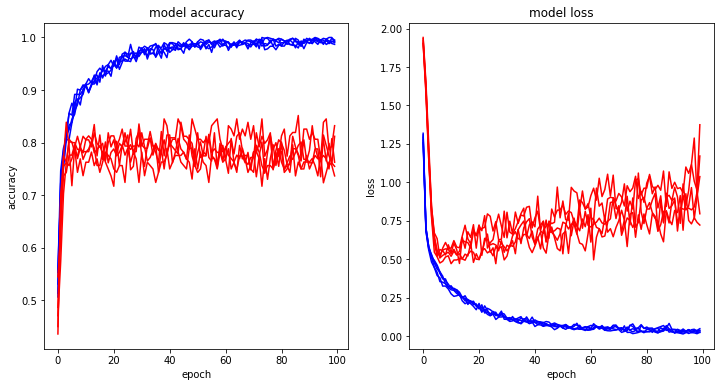

In [79]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(np.vstack([_['accuracy'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_accuracy'] for _ in hists]).T, 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(np.vstack([_['loss'] for _ in hists]).T, 'b')
plt.plot(np.vstack([_['val_loss'] for _ in hists]).T, 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Our goal is for the deep model to do at least as well as logistic regression, which gave cross-validated classification accuracies of ~60% and ~83% in two datasets. Using the EEGNet CNN, we achieve ~75% and 86% (+-4%). The improvement on the first dataset improves classification above the unofficial threshold for acceptable BCI performance.

We expect the deep model will be useful in other ways too.

## Inspecting the model

We're doing a little better than we did with logistic regression,
but let's see what we can learn from/about the model.

[Further info](http://cs231n.github.io/understanding-cnn/)



In [22]:
# Load the 'best' model from disk.
from tensorflow.keras.models import load_model
model = load_model(datadir / 'converted' / (SESS_ID + '_model{}_best.h5'.format(np.argmax(best_val_accs))))
# model.summary()

### First convolutional layer
The first convolutional layer is simply performing time-domain convolution. Interpreting this layer is similar to visualizing filter characteristics.

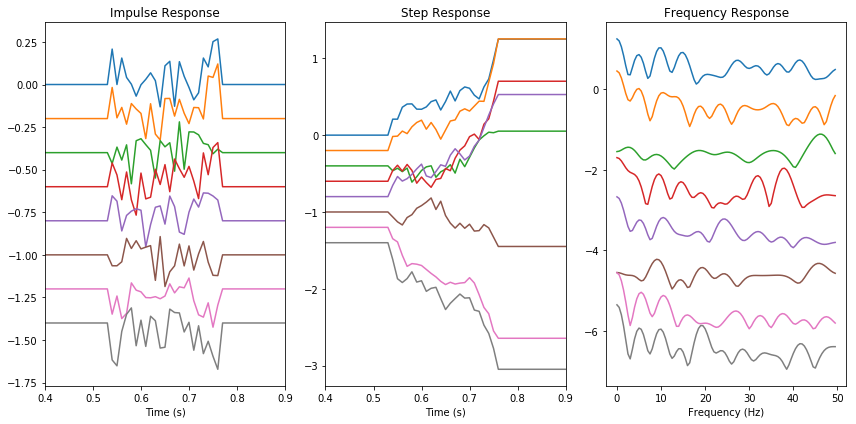

In [54]:
import scipy.signal

filters = np.squeeze(model.layers[0].get_weights()[0])
t = ax_info['timestamps']

fig = plt.figure(figsize=(12, 6), facecolor='white')

# Impulse response
impulse = np.zeros_like(t)
impulse[int(len(t)//2)] = 1.0
plt.subplot(1, 3, 1)
for filt_ix, filt_coeff in enumerate(filters.T):
    imp_conv = scipy.signal.convolve(impulse, filt_coeff, 'same')
    plt.plot(t, imp_conv - 0.2*filt_ix)
plt.xlim((0.4, 0.9))
plt.xlabel('Time (s)')
plt.title('Impulse Response')

# Step response
step = np.zeros_like(t)
step[int(len(t)//2):] = 1.0
plt.subplot(1, 3, 2)
for filt_ix, filt_coeff in enumerate(filters.T):
    step_response = scipy.signal.convolve(step, filt_coeff, 'same')
    plt.plot(t, step_response - 0.2*filt_ix)
plt.xlim((0.4, 0.9))
plt.xlabel('Time (s)')
plt.title('Step Response')

plt.subplot(1, 3, 3)
for filt_ix, filt_coeff in enumerate(filters.T):
    f, resp = scipy.signal.freqz(filt_coeff, worN=int(ax_info['fs']), fs=ax_info['fs'])
    plt.plot(f, np.abs(resp) - filt_ix)
plt.xlabel('Frequency (Hz)')
plt.title('Frequency Response')

plt.tight_layout()

### Spatial filter
The second convolutional layer in our model is a set of spatial filters. We can visualize the weights that transform the 32-channel inputs to D*n_temporal_filter features.

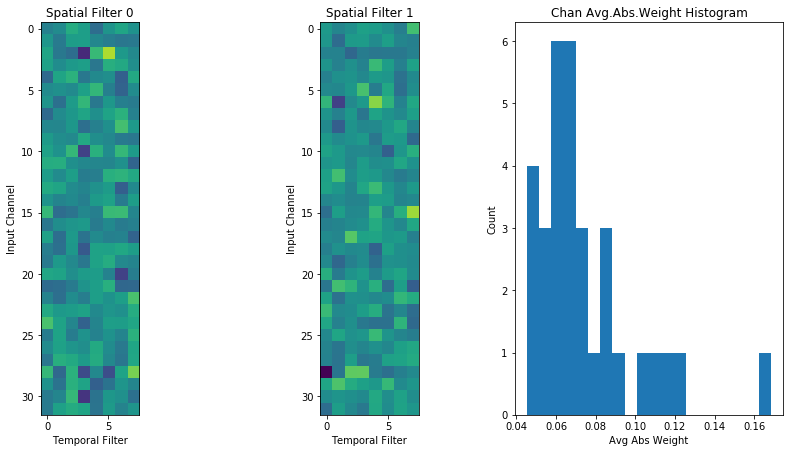

In [55]:
spatial_filter = np.squeeze(model.layers[2].get_weights()[0])
D = spatial_filter.shape[-1]
sp_dim = int(np.ceil(np.sqrt(D)))
vmax=abs(spatial_filter).max()
vmin=-abs(spatial_filter).max()
fig = plt.figure(figsize=(12, 12), facecolor='white')
for depth_ix in range(D):
    plt.subplot(sp_dim, sp_dim+1, depth_ix + 1)
    plt.imshow(spatial_filter[:, :, depth_ix], vmax=vmax, vmin=vmin)
    plt.title('Spatial Filter Set {}'.format(depth_ix))
    plt.xlabel('Temporal Filter')
    plt.ylabel('Input Channel')
# plt.colorbar()
plt.subplot(sp_dim, sp_dim+1, D+1)
avg_abs_weight = np.mean(np.mean(np.abs(spatial_filter), axis=1), axis=-1)
# plt.bar(np.arange(spatial_filter.shape[0]), avg_abs_weight)
# plt.xlabel('Channel ID')
# plt.ylabel('Avg Abs Weight')
plt.hist(avg_abs_weight, 20)
plt.xlabel('Avg Abs Weight')
plt.ylabel('Count')
plt.title('Chan Avg.Abs.Weight Histogram')
plt.tight_layout()
plt.show()

There seems to be a small group of channels with large weights, another group with intermediate weights, and finally the rest of the channels with low weights.

# Maximum activations

For the remaining layers, it's difficult to conceptualize what data they represent simply by looking at their weights.
A more useful representation is to visualize an input that would maximize activation of a given filter. How do we do that?

Remembering back to the manual step-by-step neural net in 02_02, we found the _weights_ that _minimized_ a loss function. Now we know the weights but we want to find the _inputs_ that _maximize_ some other function related to the activation (a.k.a. output) of a filter. The new functions isn't really a 'loss', but we're going to use the same training framework so we'll hijack the loss function. A common loss function for this task is to simply take the Mean of the output of the layer and filter of interest.

We start with a random input and call the model on the input while recording with GradientTape. Then, instead of using our gradients to 'optimize loss' (i.e., step the weights down the gradients), we use our gradients to modify the input (i.e., step the input up the gradients). Repeat with the new input until we have an input that maximizes our 'loss'.

In [ ]:
from tensorflow.keras import backend as K
LAYER_IX = 6  # [2, 6, 10, 14]
FILTER_IX = 0
N_STEPS = 200

max_model = tf.keras.Model(model.input, model.layers[LAYER_IX].output[:, :, FILTER_IX])
input_data = tf.convert_to_tensor(np.random.randn(*X.shape[1:]).astype(np.float32)[None, :, :])
for step_ix in range(N_STEPS):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        filter_act = max_model(input_data)
        loss_value = K.mean(filter_act)
    grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
    # Normalize gradients
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
    input_data += grads
print(loss_value.numpy())

In [ ]:
max_activation = input_data.numpy()[0]
plt.plot(max_activation[:, ch_ids[:3]])
plt.show()

Let's plot filter activation maximization signals for ~4 filters from each of the CNN layers.
This uses a [helper function from the repository](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/indl/cnn_helper_1D.py#L77-L149).

In [ ]:
from indl.cnn_helper_1D import visualize_layer, _stitch_filters
layer_idx = 10  # [2, 6, 10, 14]
max_acts = visualize_layer(model, layer_idx,
                           upsampling_steps=1, upsampling_factor=1,
                           filter_range=(0, 20),
                           output_dim=(701, model.get_input_shape_at(0)[-1]))
stitched_data = _stitch_filters(max_acts)

import matplotlib.pyplot as plt

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))

fig = plt.figure(figsize=(10, 6))
for chan_ix in ch_ids[:3]:
    plt.plot(stitched_data[:, :, chan_ix], color=next(colour_codes))
plt.show()

### Class Activation Maximization
If we extend our reasoning from filter activations down to the very last layer, and we choose a 'loss' that maximizes one class and minimizes the others, we can plot maximization signals for each of the 3 output classes.

In [ ]:
layer_idx = 20
# When processing softmax classification layer,
# second last dense layer should be converted from relu to linear.
if (layer_idx == len(model.layers) - 1) and (model.layers[-2].activation != tf.keras.activations.linear):
    model.layers[-2].activation = tf.keras.activations.linear
    import tempfile
    # Save and load the model to actually apply the change.
    tmp_path = Path(tempfile.gettempdir()) / (next(tempfile._get_candidate_names()) + '.h5')
    try:
        model.save(str(tmp_path))
        model = load_model(str(tmp_path))
    finally:
        tmp_path.unlink()

In [ ]:
from indl.cnn_helper_1D import visualize_layer, _stitch_filters
max_acts = visualize_layer(model, layer_idx, loss_as_exclusive=True,
                           upsampling_steps=1, upsampling_factor=1,
                           filter_range=(0, 10),
                           output_dim=(701, model.get_input_shape_at(0)[-1]))
stitched_data = _stitch_filters(max_acts, n=2, sort_by_activation=False)

import matplotlib.pyplot as plt

# Create a colour code cycler e.g. 'C0', 'C1', etc.
from itertools import cycle
colour_codes = map('C{}'.format, cycle(range(10)))

fig = plt.figure(figsize=(8, 5))
for chan_ix in ch_ids[:3]:
    plt.plot(stitched_data[:, :, chan_ix], color=next(colour_codes))
plt.show()

### Saliency Maps
Saliency maps visualize how each part of a real input contributes to the loss.

In [ ]:
from tensorflow.keras import backend as K
N_TRIALS = 9
test_class = 'ISI'
classes, y = np.unique(Y, return_inverse=True)
trial_ids = np.where(y == classes.tolist().index(test_class))[0]

losses_grads = []
for tr_id in trial_ids:
    input_data = tf.convert_to_tensor(X[tr_id, :, :].astype(np.float32)[None, :, :])
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        class_proba = model(input_data)
        loss_value = K.sparse_categorical_crossentropy(y[tr_id], class_proba)
    grads = tape.gradient(loss_value, input_data)  # Derivative of loss w.r.t. input
    # Normalize gradients
    grads /= (K.sqrt(K.mean(K.square(grads))) + K.epsilon())
    losses_grads.append((loss_value, grads))

In [ ]:
loss_vals = [_[0][0].numpy() for _ in losses_grads]
grad_vals = np.concatenate([_[1].numpy() for _ in losses_grads], axis=0)
re_ix = np.argsort(loss_vals)
_x = X[trial_ids][re_ix][:3]
_masks = grad_vals[re_ix][:3]

for tr_ix in range(3):
    plt.subplot(3, 1, tr_ix + 1)
    plt.plot(_x[tr_ix, :, ch_ids[0]])
    ax2=plt.twinx()
    ax2.plot(_masks[tr_ix, :, ch_ids[0]], 'k')

### Class Activation Maps
Class activation maps highlight the parts of the input that contribute most to each classification score.
This is similar but different to saliency mapping, and has largely replaced saliency mapping.
While we don't have any code to do class activation mapping (yet), there are a couple examples in the slides for Part 3.

# Hyperparameter Optimization

Our model had many hyperparameters. Here we search for their optimal values.

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit
P_TRAIN = 0.8

def evaluate_model(params, verbose=0):
    print(params)
    n_temporal_filters = params.get('n_temporal_filters', 8)
    kern_length_1 = params.get('kern_length_1', 24)
    downsamp_1 = params.get('downsamp_1', 3)
    D = params.get('D', 2)
    n_pointwise_filters = params.get('n_pointwise_filters', 44)
    kern_length_2 = params.get('kern_length_2', 11)  # int(kern_length_1 // downsamp_1))
    downsamp_2 = params.get('downsamp_2', 3)
    n_last_filters = params.get('n_last_filters', 16)
    kern_length_3 = params.get('kern_length_3', 6)  # int(kern_length_2 // downsamp_2))
    downsamp_3 = params.get('downsamp_3', 2)
    norm_rate = params.get('norm_rate', 0.2)
    dropout_rate = params.get('dropout_rate', 0.4)
    l2_reg = params.get('l2_reg', 0.001)
    epochs = params.get('epochs', 100)
    
    # Get the training/testing data for this split.
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN)
    b_train, b_test = next(sss.split(X, Y))
    ds_train, ds_valid, n_train = get_ds_train_valid(X, Y, b_train, b_test, batch_size=BATCH_SIZE, max_offset=MAX_OFFSET)
    
    model = make_model(X.shape[1], X.shape[2],
                       n_temporal_filters=n_temporal_filters,
                       kern_length_1=kern_length_1, downsamp_1=downsamp_1,
                       D=D,
                       n_pointwise_filters=n_pointwise_filters, kern_length_2=kern_length_2, downsamp_2=downsamp_2,
                       n_last_filters=n_last_filters, kern_length_3=kern_length_3, downsamp_3=downsamp_3,
                       norm_rate=norm_rate, dropout_rate=dropout_rate, l2_reg=l2_reg)
    
    history = model.fit(x=ds_train, epochs=epochs, validation_data=ds_valid, verbose=verbose)
    min_val_loss = min(history.history['val_loss'])
    
    reset_keras(model)
    reset_keras(model)  # Just to be sure...
    
    return min_val_loss

In [65]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
from hyperopt.pyll import scope

trials = None
hyperoptBest = None
del trials
del hyperoptBest


space = {
    'n_temporal_filters': scope.int(hp.quniform('n_temporal_filters', 2, 65, 1)),
    'kern_length_1': scope.int(hp.quniform('kern_length_1', 4, 64, 1)),
#     'downsamp_1': scope.int(hp.quniform('downsamp_1', 2, 9, 1)),
    'D': scope.int(hp.quniform('D', 1, 8, 1)),
    'n_pointwise_filters': scope.int(hp.quniform('n_pointwise_filters', 2, 65, 1)),
    'kern_length_2': scope.int(hp.quniform('kern_length_2', 4, 32, 1)),
#     'downsamp_2': scope.int(hp.quniform('downsamp_2', 2, 8, 1)),
    'n_last_filters': scope.int(hp.quniform('n_last_filters', 2, 65, 1)),
    'kern_length_3': scope.int(hp.quniform('kern_length_3', 2, 32, 1)),
#     'downsamp_3': scope.int(hp.quniform('downsamp_3', 2, 8, 1)),
    'norm_rate': hp.uniform('norm_rate', 0., 0.5),
    'dropout_rate': hp.uniform('dropout_rate', 0., 0.5),
    'l2_reg': hp.loguniform('l2_reg', np.log(0.000001), np.log(0.1)),
#     'epochs': scope.int(hp.quniform('epochs', 60, 300, 20)),
}

trials = Trials()  # object that holds iteration results
#Do optimization
hyperoptBest = fmin(evaluate_model, space, algo=tpe.suggest, max_evals=400, trials=trials)
print("Best Loss: {}".format(trials.best_trial['result']['loss']))
print("Best Parameters: {}".format(hyperoptBest))

{'D': 1, 'dropout_rate': 0.06328799141609559, 'kern_length_1': 23, 'kern_length_2': 31, 'kern_length_3': 9, 'l2_reg': 3.3021865067157916e-05, 'n_last_filters': 25, 'n_pointwise_filters': 40, 'n_temporal_filters': 31, 'norm_rate': 0.3454019972061737}
14                                                                                                                     
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.1439778767646297, 'kern_length_1': 32, 'kern_length_2': 32, 'kern_length_3': 8, 'l2_reg': 7.061424619433587e-05, 'n_last_filters': 19, 'n_pointwise_filters': 9, 'n_temporal_filters': 9, 'norm_rate': 0.003854788932738329}
14                                                                                                                     
210                                                                                                                    
{'D': 7, 'dropout_rate

14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.08760816196830412, 'kern_length_1': 39, 'kern_length_2': 31, 'kern_length_3': 24, 'l2_reg': 0.007927498671736723, 'n_last_filters': 48, 'n_pointwise_filters': 23, 'n_temporal_filters': 28, 'norm_rate': 0.25925231603101134}
14                                                                                                                     
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.3420604974185684, 'kern_length_1': 28, 'kern_length_2': 19, 'kern_length_3': 18, 'l2_reg': 0.07396010688316317, 'n_last_filters': 40, 'n_pointwise_filters': 44, 'n_temporal_filters': 9, 'norm_rate': 0.3999668175017731}
14                      

{'D': 7, 'dropout_rate': 0.1033502283323175, 'kern_length_1': 57, 'kern_length_2': 23, 'kern_length_3': 31, 'l2_reg': 1.383409518296496e-05, 'n_last_filters': 37, 'n_pointwise_filters': 39, 'n_temporal_filters': 25, 'norm_rate': 0.35592134143073034}
14                                                                                                                     
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.15779685766362303, 'kern_length_1': 50, 'kern_length_2': 27, 'kern_length_3': 28, 'l2_reg': 1.3886278660674298e-06, 'n_last_filters': 45, 'n_pointwise_filters': 32, 'n_temporal_filters': 11, 'norm_rate': 0.16680605882472338}
14                                                                                                                     
210                                                                                                                    
{'D': 7, 'dropout_

14                                                                                                                     
210                                                                                                                    
{'D': 6, 'dropout_rate': 0.31451601186671896, 'kern_length_1': 35, 'kern_length_2': 28, 'kern_length_3': 10, 'l2_reg': 7.087566947143245e-06, 'n_last_filters': 8, 'n_pointwise_filters': 19, 'n_temporal_filters': 9, 'norm_rate': 0.027638344731920478}
14                                                                                                                     
210                                                                                                                    
{'D': 1, 'dropout_rate': 0.49788950500885004, 'kern_length_1': 55, 'kern_length_2': 10, 'kern_length_3': 18, 'l2_reg': 2.9446439900260694e-05, 'n_last_filters': 28, 'n_pointwise_filters': 31, 'n_temporal_filters': 17, 'norm_rate': 0.10239823223006966}
14                

{'D': 2, 'dropout_rate': 0.46448991443752813, 'kern_length_1': 60, 'kern_length_2': 8, 'kern_length_3': 31, 'l2_reg': 1.6454967371333786e-05, 'n_last_filters': 48, 'n_pointwise_filters': 38, 'n_temporal_filters': 11, 'norm_rate': 0.2056986359669133}
14                                                                                                                     
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.43603477354635056, 'kern_length_1': 52, 'kern_length_2': 16, 'kern_length_3': 26, 'l2_reg': 0.0009227193012737782, 'n_last_filters': 59, 'n_pointwise_filters': 27, 'n_temporal_filters': 2, 'norm_rate': 0.23889662723010552}
14                                                                                                                     
210                                                                                                                    
{'D': 6, 'dropout_ra

14                                                                                                                     
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.023381778144208637, 'kern_length_1': 48, 'kern_length_2': 32, 'kern_length_3': 13, 'l2_reg': 0.0052479158722507436, 'n_last_filters': 58, 'n_pointwise_filters': 59, 'n_temporal_filters': 22, 'norm_rate': 0.4971678703558288}
14                                                                                                                     
210                                                                                                                    
{'D': 8, 'dropout_rate': 0.1313265810480282, 'kern_length_1': 41, 'kern_length_2': 29, 'kern_length_3': 27, 'l2_reg': 0.00029586530134046406, 'n_last_filters': 20, 'n_pointwise_filters': 48, 'n_temporal_filters': 7, 'norm_rate': 0.037676425127904256}
14                

{'D': 1, 'dropout_rate': 0.18571248248353772, 'kern_length_1': 7, 'kern_length_2': 5, 'kern_length_3': 22, 'l2_reg': 4.520752588716788e-06, 'n_last_filters': 38, 'n_pointwise_filters': 12, 'n_temporal_filters': 60, 'norm_rate': 0.459510938376271}
14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.31172752459164466, 'kern_length_1': 5, 'kern_length_2': 6, 'kern_length_3': 19, 'l2_reg': 1.4467155772177208e-05, 'n_last_filters': 30, 'n_pointwise_filters': 9, 'n_temporal_filters': 64, 'norm_rate': 0.48701333889839354}
14                                                                                                                     
210                                                                                                                    
{'D': 1, 'dropout_rate':

210                                                                                                                    
{'D': 4, 'dropout_rate': 0.14428623395204787, 'kern_length_1': 4, 'kern_length_2': 17, 'kern_length_3': 26, 'l2_reg': 1.3376577793143485e-06, 'n_last_filters': 17, 'n_pointwise_filters': 3, 'n_temporal_filters': 36, 'norm_rate': 0.3413277050228479}
14                                                                                                                     
210                                                                                                                    
{'D': 1, 'dropout_rate': 0.31627767945678087, 'kern_length_1': 18, 'kern_length_2': 15, 'kern_length_3': 16, 'l2_reg': 1.014444465921038e-06, 'n_last_filters': 29, 'n_pointwise_filters': 23, 'n_temporal_filters': 60, 'norm_rate': 0.4634947781206096}
14                                                                                                                     
210                  

14                                                                                                                     
210                                                                                                                    
{'D': 1, 'dropout_rate': 0.209762812329097, 'kern_length_1': 18, 'kern_length_2': 17, 'kern_length_3': 15, 'l2_reg': 6.149467059996002e-05, 'n_last_filters': 7, 'n_pointwise_filters': 31, 'n_temporal_filters': 48, 'norm_rate': 0.29962333180354306}
14                                                                                                                     
210                                                                                                                    
{'D': 4, 'dropout_rate': 0.37933000751012697, 'kern_length_1': 24, 'kern_length_2': 15, 'kern_length_3': 27, 'l2_reg': 1.3332675593490047e-05, 'n_last_filters': 57, 'n_pointwise_filters': 4, 'n_temporal_filters': 60, 'norm_rate': 0.4185111831870777}
14                    

{'D': 2, 'dropout_rate': 0.28123544056393973, 'kern_length_1': 8, 'kern_length_2': 25, 'kern_length_3': 24, 'l2_reg': 7.510468511650509e-06, 'n_last_filters': 45, 'n_pointwise_filters': 11, 'n_temporal_filters': 55, 'norm_rate': 0.4194491975810984}
14                                                                                                                     
210                                                                                                                    
{'D': 1, 'dropout_rate': 0.38821184610005866, 'kern_length_1': 21, 'kern_length_2': 14, 'kern_length_3': 27, 'l2_reg': 1.1891137100750098e-06, 'n_last_filters': 51, 'n_pointwise_filters': 5, 'n_temporal_filters': 58, 'norm_rate': 0.3075307390559617}
14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rat

14                                                                                                                     
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.46310570755476366, 'kern_length_1': 38, 'kern_length_2': 26, 'kern_length_3': 10, 'l2_reg': 1.464867761947234e-06, 'n_last_filters': 48, 'n_pointwise_filters': 49, 'n_temporal_filters': 48, 'norm_rate': 0.31148411146178595}
14                                                                                                                     
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.4807427324835972, 'kern_length_1': 35, 'kern_length_2': 21, 'kern_length_3': 11, 'l2_reg': 1.8587112678669753e-06, 'n_last_filters': 52, 'n_pointwise_filters': 39, 'n_temporal_filters': 38, 'norm_rate': 0.3939055930618162}
14                 

{'D': 5, 'dropout_rate': 0.4647067474279519, 'kern_length_1': 28, 'kern_length_2': 22, 'kern_length_3': 9, 'l2_reg': 3.7943373944256838e-06, 'n_last_filters': 29, 'n_pointwise_filters': 42, 'n_temporal_filters': 62, 'norm_rate': 0.4683775616946906}
14                                                                                                                     
210                                                                                                                    
{'D': 4, 'dropout_rate': 0.410672966487622, 'kern_length_1': 30, 'kern_length_2': 14, 'kern_length_3': 16, 'l2_reg': 0.02193814029438043, 'n_last_filters': 63, 'n_pointwise_filters': 38, 'n_temporal_filters': 65, 'norm_rate': 0.3513427632038956}
14                                                                                                                     
210                                                                                                                    
{'D': 1, 'dropout_rate': 

14                                                                                                                     
210                                                                                                                    
{'D': 6, 'dropout_rate': 0.4887051318794533, 'kern_length_1': 28, 'kern_length_2': 12, 'kern_length_3': 17, 'l2_reg': 3.87884996647528e-06, 'n_last_filters': 44, 'n_pointwise_filters': 22, 'n_temporal_filters': 60, 'norm_rate': 0.42820552416355623}
14                                                                                                                     
210                                                                                                                    
{'D': 2, 'dropout_rate': 0.09260054241751212, 'kern_length_1': 24, 'kern_length_2': 28, 'kern_length_3': 23, 'l2_reg': 0.00010979337599479301, 'n_last_filters': 64, 'n_pointwise_filters': 37, 'n_temporal_filters': 52, 'norm_rate': 0.49998562863163615}
14                 

{'D': 4, 'dropout_rate': 0.4524288292532575, 'kern_length_1': 8, 'kern_length_2': 4, 'kern_length_3': 10, 'l2_reg': 6.649792197402606e-06, 'n_last_filters': 38, 'n_pointwise_filters': 43, 'n_temporal_filters': 44, 'norm_rate': 0.3044845226055608}
14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.24910251282148177, 'kern_length_1': 12, 'kern_length_2': 9, 'kern_length_3': 18, 'l2_reg': 3.490995331335095e-06, 'n_last_filters': 59, 'n_pointwise_filters': 52, 'n_temporal_filters': 54, 'norm_rate': 0.2674301610462836}
14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rate':

14                                                                                                                     
210                                                                                                                    
{'D': 2, 'dropout_rate': 0.1289479079412645, 'kern_length_1': 34, 'kern_length_2': 13, 'kern_length_3': 25, 'l2_reg': 3.718475614147143e-06, 'n_last_filters': 43, 'n_pointwise_filters': 53, 'n_temporal_filters': 61, 'norm_rate': 0.3136874613870131}
14                                                                                                                     
210                                                                                                                    
{'D': 5, 'dropout_rate': 0.43645244812599837, 'kern_length_1': 30, 'kern_length_2': 4, 'kern_length_3': 19, 'l2_reg': 0.001637108345318329, 'n_last_filters': 48, 'n_pointwise_filters': 32, 'n_temporal_filters': 37, 'norm_rate': 0.3489755025170277}
14                     

{'D': 4, 'dropout_rate': 0.3451774761115426, 'kern_length_1': 31, 'kern_length_2': 12, 'kern_length_3': 13, 'l2_reg': 4.6595555392793515e-06, 'n_last_filters': 58, 'n_pointwise_filters': 32, 'n_temporal_filters': 38, 'norm_rate': 0.3572616296015898}
14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.32749915442305955, 'kern_length_1': 22, 'kern_length_2': 13, 'kern_length_3': 14, 'l2_reg': 2.0790747506895096e-06, 'n_last_filters': 51, 'n_pointwise_filters': 40, 'n_temporal_filters': 41, 'norm_rate': 0.38913939113759716}
14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_

14                                                                                                                     
210                                                                                                                    
{'D': 1, 'dropout_rate': 0.36996217869642295, 'kern_length_1': 16, 'kern_length_2': 14, 'kern_length_3': 18, 'l2_reg': 1.3773365411489184e-05, 'n_last_filters': 54, 'n_pointwise_filters': 14, 'n_temporal_filters': 53, 'norm_rate': 0.447440792392609}
14                                                                                                                     
210                                                                                                                    
{'D': 2, 'dropout_rate': 0.4331652659399227, 'kern_length_1': 19, 'kern_length_2': 23, 'kern_length_3': 22, 'l2_reg': 7.3274560004306555e-06, 'n_last_filters': 59, 'n_pointwise_filters': 24, 'n_temporal_filters': 65, 'norm_rate': 0.45975680185476214}
14                 

{'D': 2, 'dropout_rate': 0.4556065477263277, 'kern_length_1': 23, 'kern_length_2': 6, 'kern_length_3': 14, 'l2_reg': 3.387411821310189e-05, 'n_last_filters': 44, 'n_pointwise_filters': 10, 'n_temporal_filters': 51, 'norm_rate': 0.4062665400293758}
14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.3367444431817543, 'kern_length_1': 28, 'kern_length_2': 10, 'kern_length_3': 21, 'l2_reg': 1.1238277212837996e-05, 'n_last_filters': 40, 'n_pointwise_filters': 50, 'n_temporal_filters': 57, 'norm_rate': 0.18524715493278887}
14                                                                                                                     
210                                                                                                                    
{'D': 4, 'dropout_rat

210                                                                                                                    
{'D': 4, 'dropout_rate': 0.4174710511084167, 'kern_length_1': 5, 'kern_length_2': 6, 'kern_length_3': 20, 'l2_reg': 1.242661109903791e-06, 'n_last_filters': 47, 'n_pointwise_filters': 44, 'n_temporal_filters': 57, 'norm_rate': 0.2768056492722891}
14                                                                                                                     
210                                                                                                                    
{'D': 2, 'dropout_rate': 0.28164811415807334, 'kern_length_1': 10, 'kern_length_2': 12, 'kern_length_3': 18, 'l2_reg': 5.143424151587127e-06, 'n_last_filters': 44, 'n_pointwise_filters': 41, 'n_temporal_filters': 60, 'norm_rate': 0.397986046322502}
14                                                                                                                     
210                     

{'D': 3, 'dropout_rate': 0.4313672885780654, 'kern_length_1': 25, 'kern_length_2': 14, 'kern_length_3': 11, 'l2_reg': 1.1897402554205154e-05, 'n_last_filters': 55, 'n_pointwise_filters': 26, 'n_temporal_filters': 64, 'norm_rate': 0.3956078258619869}
14                                                                                                                     
210                                                                                                                    
{'D': 4, 'dropout_rate': 0.3983985313829451, 'kern_length_1': 10, 'kern_length_2': 15, 'kern_length_3': 12, 'l2_reg': 7.641438968767603e-05, 'n_last_filters': 53, 'n_pointwise_filters': 28, 'n_temporal_filters': 59, 'norm_rate': 0.3686599578436543}
14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rat

14                                                                                                                     
210                                                                                                                    
{'D': 4, 'dropout_rate': 0.4515533272099724, 'kern_length_1': 30, 'kern_length_2': 16, 'kern_length_3': 11, 'l2_reg': 2.566373199027289e-06, 'n_last_filters': 44, 'n_pointwise_filters': 28, 'n_temporal_filters': 49, 'norm_rate': 0.4524983601152634}
14                                                                                                                     
210                                                                                                                    
{'D': 2, 'dropout_rate': 0.3879483100293165, 'kern_length_1': 20, 'kern_length_2': 7, 'kern_length_3': 9, 'l2_reg': 0.09980880606509221, 'n_last_filters': 36, 'n_pointwise_filters': 41, 'n_temporal_filters': 53, 'norm_rate': 0.3768984669944809}
14                        

{'D': 3, 'dropout_rate': 0.44079234815269475, 'kern_length_1': 28, 'kern_length_2': 14, 'kern_length_3': 11, 'l2_reg': 9.973682060753399e-06, 'n_last_filters': 54, 'n_pointwise_filters': 13, 'n_temporal_filters': 53, 'norm_rate': 0.49159422252950835}
14                                                                                                                     
210                                                                                                                    
{'D': 4, 'dropout_rate': 0.1442345787158592, 'kern_length_1': 25, 'kern_length_2': 4, 'kern_length_3': 2, 'l2_reg': 0.00017065205531974976, 'n_last_filters': 43, 'n_pointwise_filters': 35, 'n_temporal_filters': 35, 'norm_rate': 0.019787712716390432}
14                                                                                                                     
210                                                                                                                    
{'D': 1, 'dropout_r

14                                                                                                                     
210                                                                                                                    
{'D': 1, 'dropout_rate': 0.40148692711705825, 'kern_length_1': 16, 'kern_length_2': 11, 'kern_length_3': 18, 'l2_reg': 4.347096045704436e-06, 'n_last_filters': 56, 'n_pointwise_filters': 38, 'n_temporal_filters': 51, 'norm_rate': 0.4426656893782909}
14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.3563022540254912, 'kern_length_1': 7, 'kern_length_2': 10, 'kern_length_3': 11, 'l2_reg': 1.2872303733452846e-06, 'n_last_filters': 59, 'n_pointwise_filters': 40, 'n_temporal_filters': 44, 'norm_rate': 0.48594816929281387}
14                  

{'D': 4, 'dropout_rate': 0.42406973646768426, 'kern_length_1': 26, 'kern_length_2': 20, 'kern_length_3': 15, 'l2_reg': 3.0272463919245393e-06, 'n_last_filters': 26, 'n_pointwise_filters': 56, 'n_temporal_filters': 65, 'norm_rate': 0.4273205307598002}
14                                                                                                                     
210                                                                                                                    
{'D': 6, 'dropout_rate': 0.4710789452114657, 'kern_length_1': 32, 'kern_length_2': 14, 'kern_length_3': 20, 'l2_reg': 1.104210995612027e-06, 'n_last_filters': 25, 'n_pointwise_filters': 44, 'n_temporal_filters': 41, 'norm_rate': 0.35246446350202104}
14                                                                                                                     
210                                                                                                                    
{'D': 5, 'dropout_r

14                                                                                                                     
210                                                                                                                    
{'D': 3, 'dropout_rate': 0.36591991394415213, 'kern_length_1': 15, 'kern_length_2': 17, 'kern_length_3': 18, 'l2_reg': 0.004493290728065885, 'n_last_filters': 63, 'n_pointwise_filters': 36, 'n_temporal_filters': 39, 'norm_rate': 0.31786702071667255}
14                                                                                                                     
210                                                                                                                    
{'D': 7, 'dropout_rate': 0.4177903405238155, 'kern_length_1': 40, 'kern_length_2': 16, 'kern_length_3': 17, 'l2_reg': 0.0028909318058094203, 'n_last_filters': 55, 'n_pointwise_filters': 31, 'n_temporal_filters': 52, 'norm_rate': 0.3831365712198856}
14                   